In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
# import os
# import pandas as pd

2023-06-15 17:01:58.246954: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Dataset preparation

### Set parameters

In [2]:
batch_size = 32
img_height = 184
img_width = 216
img_size = (img_height, img_width)
img_shape = img_size + (3,)

### Load dataset

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

train_path = "/drive0-storage/Gracia/Dataset/dataset_4/training"
val_path = "/drive0-storage/Gracia/Dataset/dataset_4/validation"

with tf.device("CPU"):
    train_ds = image_dataset_from_directory(train_path,
                                        seed = 123,
                                        image_size = img_size,
                                        batch_size = batch_size)
    
    val_ds = image_dataset_from_directory(val_path,
                                      seed = 456,
                                      image_size = img_size,
                                      batch_size = batch_size)

2023-06-15 17:02:00.568244: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 17:02:01.209859: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1637] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38215 MB memory:  -> device: 0, name: A100-SXM4-40GB MIG 7g.40gb, pci bus id: 0000:0f:00.0, compute capability: 8.0


Found 30732 files belonging to 3 classes.
Found 7680 files belonging to 3 classes.


In [4]:
# os.rmdir("/drive0-storage/Gracia/dataset_1/.ipynb_checkpoints")

In [5]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['bipolar_disorder', 'healthy_controls', 'schizophrenia']


<dtype: 'float32'>
0.0 246.96866
(184, 216, 3)


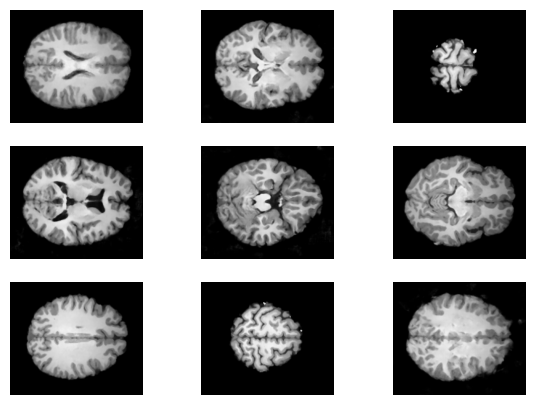

In [6]:
with tf.device("CPU"):
    plt.figure(figsize=(7,5))
    for images, labels in train_ds.take(1):
        org_image = images[0]
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")

    print(org_image.dtype)
    print(np.min(org_image), np.max(org_image))
    print(org_image.shape)

### Test set

In [6]:
with tf.device("CPU"):
    val_batches = tf.data.experimental.cardinality(val_ds)
    test_dataset = val_ds.take(val_batches // 2)
    validation_dataset = val_ds.skip(val_batches // 2)
    
    # Buffered prefetching
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
    test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [7]:
print(len(validation_dataset))
print(len(test_dataset))

120
120


## Model building

In [8]:
def build_vgg16():
    model = Sequential()
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=img_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Flatten the output and create fully connected layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(num_classes, activation='softmax'))  
    
    return model

In [9]:
with tf.device("GPU"):
    model = build_vgg16()
    
    # compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                  metrics=['accuracy'])

## Model training

In [11]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.99):
            print("\nReached 99% accuracy, cancelling training")
            self.model.stop_training = True
            
callbacks = myCallback()
save_locally = tf.saved_model.SaveOptions(experimental_io_device='/job:localhost')
checkpoints_cb = tf.keras.callbacks.ModelCheckpoint('./cnn4_checkpoints', options=save_locally)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

In [12]:
EPOCH = 30

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            batch_size = 32,
            callbacks=[callbacks])

Epoch 1/30


2023-06-15 17:04:26.477662: I tensorflow/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-06-15 17:04:27.469581: I tensorflow/stream_executor/cuda/cuda_blas.cc:1633] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


961/961 [==============================] - 54s 53ms/step - loss: 0.6751 - accuracy: 0.7150 - val_loss: 1.3326 - val_accuracy: 0.3940
Epoch 2/30
961/961 [==============================] - 50s 52ms/step - loss: 0.4042 - accuracy: 0.8444 - val_loss: 0.9883 - val_accuracy: 0.5234
Epoch 3/30
961/961 [==============================] - 50s 52ms/step - loss: 0.3217 - accuracy: 0.8753 - val_loss: 0.9727 - val_accuracy: 0.5523
Epoch 4/30
961/961 [==============================] - 50s 52ms/step - loss: 0.2521 - accuracy: 0.9018 - val_loss: 1.0094 - val_accuracy: 0.5849
Epoch 5/30
961/961 [==============================] - 50s 52ms/step - loss: 0.1755 - accuracy: 0.9349 - val_loss: 0.7572 - val_accuracy: 0.7146
Epoch 6/30
961/961 [==============================] - 50s 52ms/step - loss: 0.1181 - accuracy: 0.9579 - val_loss: 0.6073 - val_accuracy: 0.7651
Epoch 7/30
961/961 [==============================] - 50s 52ms/step - loss: 0.0874 - accuracy: 0.9685 - val_loss: 0.4787 - val_accuracy: 0.8211
Epo

In [22]:
model.save('./models_retrain/cnn4_15epoch.h5')

### Training evaluation

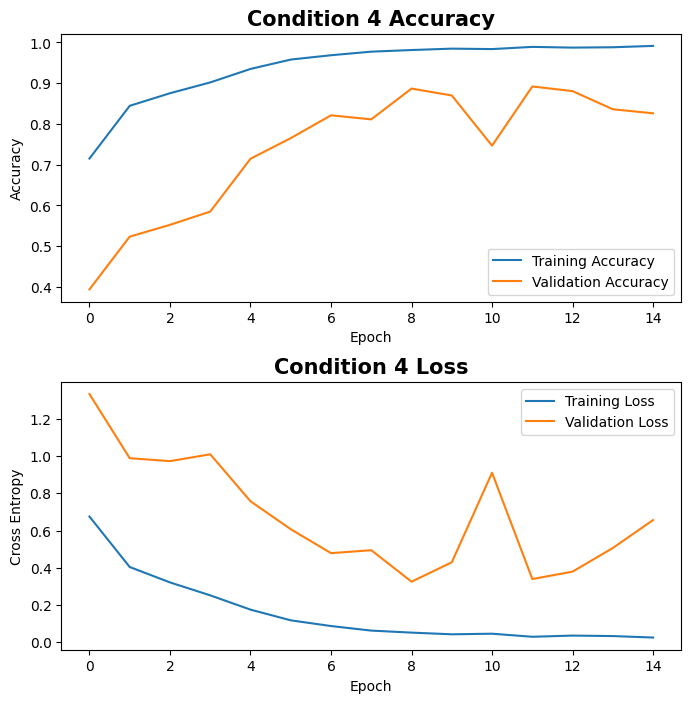

In [13]:
plt.figure(figsize=(8, 8))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
# plt.ylim([min(plt.ylim()),1])
plt.title('Condition 4 Accuracy', size=15, fontweight='bold')
plt.savefig('cnn4_acc.png')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
# plt.ylim([0,1.0])
plt.title('Condition 4 Loss', size=15, fontweight='bold')
plt.savefig('cnn4_loss.png')

plt.subplots_adjust(hspace=0.3)
plt.show()

In [14]:
acc

[0.7150201797485352,
 0.8444292545318604,
 0.8752765655517578,
 0.9018287062644958,
 0.9348887205123901,
 0.9578940272331238,
 0.9685344099998474,
 0.9772875308990479,
 0.9812898635864258,
 0.9847065210342407,
 0.9836326837539673,
 0.9890016913414001,
 0.9872445464134216,
 0.9880905747413635,
 0.9914421439170837]

In [15]:
val_acc

[0.39401042461395264,
 0.5234375,
 0.5523437261581421,
 0.5848958492279053,
 0.7145833373069763,
 0.7651041746139526,
 0.821093738079071,
 0.8111979365348816,
 0.88671875,
 0.8697916865348816,
 0.7466145753860474,
 0.8919270634651184,
 0.8804687261581421,
 0.8359375,
 0.8260416388511658]

In [16]:
loss

[0.6751402616500854,
 0.40423259139060974,
 0.32166266441345215,
 0.25214797258377075,
 0.17548613250255585,
 0.11805613338947296,
 0.0874163955450058,
 0.06289934366941452,
 0.05214032903313637,
 0.043027304112911224,
 0.04625631123781204,
 0.02983083203434944,
 0.03617718815803528,
 0.03360126540064812,
 0.025637149810791016]

In [17]:
val_loss

[1.33262300491333,
 0.9883494973182678,
 0.9726794362068176,
 1.0093802213668823,
 0.7571831941604614,
 0.607252836227417,
 0.47871464490890503,
 0.49451595544815063,
 0.3255672752857208,
 0.42963728308677673,
 0.9104383587837219,
 0.33978959918022156,
 0.3795682489871979,
 0.5064322352409363,
 0.6563262939453125]

## Testing

In [18]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sns

In [19]:
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

120/120 [==============================] - 3s 20ms/step - loss: 0.6399 - accuracy: 0.8263


{'loss': 0.639898419380188, 'accuracy': 0.8263021111488342}

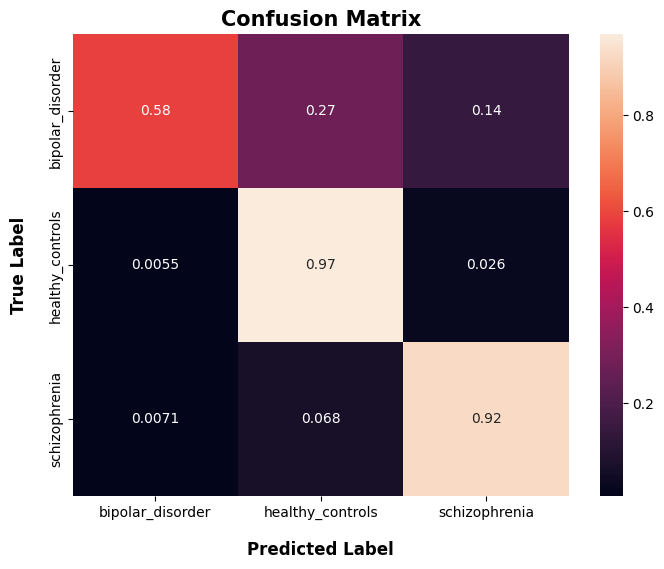

In [20]:
predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch, verbose=0)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cf_matrix, 
            annot=True)
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.xlabel('Predicted Label', labelpad=15, size=12, fontweight='bold')
plt.ylabel('True Label', labelpad=15, size=12, fontweight='bold')
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.savefig('./CNN4_cm.png')
plt.show()

In [21]:
precision = precision_score(true_labels, predicted_labels, average='weighted')
sensitivity = recall_score(true_labels, predicted_labels, average='weighted')
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(np.delete(np.delete(cf_matrix, i, axis=0), i, axis=1))
    false_positives = np.sum(cf_matrix[:, i]) - cf_matrix[i, i]
    specificity.append(true_negatives / (true_negatives + false_positives))

# Calculate average specificity
average_specificity = np.mean(specificity)

print("Accuracy:", result[1])
print("Precision:", precision)
print("Sensitivity:", sensitivity)
print("Specificity:", average_specificity)

Accuracy: 0.8263021111488342
Precision: 0.8544209359504329
Sensitivity: 0.825
Specificity: 0.9130268371116751
